In [14]:
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import json
import pydde as dde
import os

########################################
#PARAMETERS
nTimeSteps = 60; #seconds
use_case = 'varstart'
timestamp = '1507'
input_size = 15
samplenum_test = 5000
samplenum_og = 15000
criterion = nn.SmoothL1Loss()  # Huber Loss
#criterion = nn.MSELoss()  # Huber Loss
model_file_path_active = '../Trained_Models/state_dict/Model_statedict_active_' + use_case + f'_{nTimeSteps}tsteps_latest.pt'
model_file_path_passive = '../Trained_Models/state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt'
sample_file_path = f'../Data/Samples/data_'+ use_case + f'_{nTimeSteps}tsteps_'+ timestamp +'/'
simulation_file_path = '../Data/Simulations/pm_stiff.sim'
objective_file_path = f'../Data/Objectives/pm_target.obj'
#print(os.listdir(sample_file_path))

# set log level
dde.set_log_level(dde.LogLevel.off)

#######################################
# LOAD SIMULATION AND OBJECTIVE FUNCTION
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

#########################################
#LOAD ORIGINAL SAMPLES
og_number_of_files = len(os.listdir(sample_file_path))-5
with open(sample_file_path + f'data_0.json') as json_file:
    data = json.load(json_file)
    filesize = len(data['q'])
og_samplenum = filesize*og_number_of_files
og_input = np.zeros((og_samplenum, input_size))
og_loss = np.zeros(og_samplenum)
og_iterations = np.zeros(og_samplenum)
og_lineSearchIterations = np.zeros(og_samplenum)

for filenum in range(og_number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        for i, q_t in enumerate(data['q_target']):
            og_input[filenum*filesize+i, 0:3] = np.array(q_t)
        for i, q_i in enumerate(data['q']):
            og_input[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            og_input[filenum*filesize+i, 6:9] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            og_input[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            og_input[filenum*filesize+i, 12:15] = np.array(p_now_i) - og_input[filenum*filesize+i, 3:6]
        for i, truth in enumerate(data['loss']):
            og_loss[filenum*filesize+i] = np.array(truth)
        for i, iter_ in enumerate(data['iterations']):
            og_iterations[filenum*filesize+i] = np.array(iter_)
        for i, line in enumerate(data['lineSearchIterations']):
            og_lineSearchIterations[filenum*filesize+i] = np.array(line)+1


#########################################
#LOAD TEST SAMPLES
number_of_files = len(os.listdir(sample_file_path + 'data_test/'))
with open(sample_file_path+ 'data_test/' + f'data_0.json') as json_file:
    data = json.load(json_file)
    filesize = len(data['q'])
samplenum = filesize*number_of_files
input = np.zeros((samplenum, input_size))
loss = np.zeros(samplenum)
iterations = np.zeros(samplenum)
lineSearchIterations = np.zeros(samplenum)

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        for i, q_t in enumerate(data['q_target']):
            input[filenum*filesize+i, 0:3] = np.array(q_t)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 6:9] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 12:15] = np.array(p_now_i) - input[filenum*filesize+i, 3:6]
        for i, truth in enumerate(data['loss']):
            loss[filenum*filesize+i] = np.array(truth)
        for i, iter_ in enumerate(data['iterations']):
            iterations[filenum*filesize+i] = np.array(iter_)
        for i, line in enumerate(data['lineSearchIterations']):
            lineSearchIterations[filenum*filesize+i] = np.array(line)+1

        output_size = len(data['p'][0])

print(f'input_size: {input_size}, output_size: {output_size}')
print(f'Shape of og_input: {og_input.shape}')
print(f'Shape of input: {input.shape}')

#Remove zeros
og_input = og_input[~(og_input == 0).all(1)]
input = input[~(input == 0).all(1)]

print(f'og_input after removing failed samples: {og_input.shape}')
print(f'input after removing failed samples: {input.shape}')

og_input = og_input[0:samplenum_og, :]
input = input[0:samplenum_test, :]

data = torch.tensor(input).float()
og_data = torch.tensor(og_input).float()

################################
#LOAD MODEL
activeHiddenlayers = [180, 200]
class ActiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(ActiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, activeHiddenlayers[0])
        self.H1 = nn.Linear(activeHiddenlayers[0], activeHiddenlayers[1])
        #self.H1 = nn.Linear(activeHiddenlayers[0], out_sz)
        self.H2 = nn.Linear(activeHiddenlayers[1], out_sz)
        self.L_out = nn.Linear(out_sz, out_sz)
        self.Relu = nn.ReLU(inplace=True)

    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.H2(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

passiveHiddenlayers = [180, 200]
class PassiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(PassiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, passiveHiddenlayers[0])
        self.H1 = nn.Linear(passiveHiddenlayers[0], passiveHiddenlayers[1])
        self.H2 = nn.Linear(passiveHiddenlayers[1], out_sz)
        self.L_out = nn.Linear(out_sz, out_sz)
        self.Relu = nn.ReLU(inplace=True)

    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.H2(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x


active_model = ActiveLearn(input_size, output_size)
passive_model = PassiveLearn(input_size, output_size)
active_model.load_state_dict(torch.load(model_file_path_active))
passive_model.load_state_dict(torch.load(model_file_path_passive))
print("MODELS LOADED")

input_size: 15, output_size: 180
Shape of og_input: (16000, 15)
Shape of input: (6000, 15)
og_input after removing failed samples: (15937, 15)
input after removing failed samples: (5977, 15)
MODELS LOADED


In [15]:
#########################################
# METADATA
#TRAINING DATA
og_original_loss = np.mean(og_loss)
og_lineiter = sum(og_lineSearchIterations)
og_newtoniter = sum(og_iterations)
print("TRAINING DATA")
print(f'mean original loss: {og_original_loss}')
print(f'total iterations: {og_lineiter+og_newtoniter}')
print(f'lineSearchIterations: {og_lineiter}')
print(f'Newton iterations: {og_newtoniter}')

#TEST DATA
original_loss = np.mean(loss)
lineiter = sum(lineSearchIterations)
newtoniter = sum(iterations)
print('\n')
print("TEST DATA")
print(f'mean original loss: {original_loss}')
print(f'total iterations: {lineiter+newtoniter}')
print(f'lineSearchIterations: {lineiter}')
print(f'Newton iterations: {newtoniter}')
print('\n')
iter_per_sample= ((og_lineiter+og_newtoniter)/og_samplenum + (lineiter+newtoniter)/samplenum)/2
print(f'Mean iterations per sample: {iter_per_sample}')

TRAINING DATA
mean original loss: 0.003987312745315812
total iterations: 31940.0
lineSearchIterations: 16003.0
Newton iterations: 15937.0


TEST DATA
mean original loss: 0.0039453848859139305
total iterations: 11977.0
lineSearchIterations: 6000.0
Newton iterations: 5977.0


Mean iterations per sample: 1.9962083333333334


In [17]:
#########################################
# TEST PARAMETERS

#########################################
# RUN DATA THROUGH MODEL
a_losses_q= []
a_losses_p_smoothness= []
a_losses_total= []
a_losses_p_start= []

p_losses_q= []
p_losses_p_smoothness= []
p_losses_total= []
p_losses_p_start= []


with torch.no_grad():
    for i in range(samplenum_test):
        dyn.q0 = data[i, 3:6]
        dyn.qdot0 = data[i, 6:9]
        dyn.qddot0 = data[i, 9:12]
        dyn.p0 = data[i, 12:15]
        #passive model eval
        p_val_passive = passive_model(data[i, :])
        state = dyn.q(p_val_passive)
        q_traj = torch.tensor(state.q)
        loss_p_start = criterion(p_val_passive[0:dyn.nParameters], data[i,12:15])
        loss_q = criterion(q_traj[-dyn.nParameters:], data[i, 0:3])
        loss_p_smoothness = criterion(p_val_passive[0:dyn.nParameters*(nTimeSteps-1)], p_val_passive[dyn.nParameters:dyn.nParameters*nTimeSteps])
        p_losses_p_start.append(loss_p_start)
        p_losses_q.append(loss_q)
        p_losses_p_smoothness.append(loss_p_smoothness)
        p_losses_total.append(loss_q + loss_p_smoothness + loss_p_start)

        #active model eval
        p_val_active = active_model(data[i, :])
        state = dyn.q(p_val_active)
        q_traj = torch.tensor(state.q)
        loss_p_start = criterion(p_val_active[0:dyn.nParameters], data[i,12:15])
        loss_q = criterion(q_traj[-dyn.nParameters:], data[i, 0:3])
        loss_p_smoothness = criterion(p_val_active[0:dyn.nParameters*(nTimeSteps-1)], p_val_active[dyn.nParameters:dyn.nParameters*nTimeSteps])
        a_losses_p_start.append(loss_p_start)
        a_losses_q.append(loss_q)
        a_losses_p_smoothness.append(loss_p_smoothness)
        a_losses_total.append(loss_q + loss_p_smoothness + loss_p_start)

print("PASSIVE")
print(f'mean TOTAL passive loss: {np.mean(p_losses_total)}')
print(f'mean passive loss for Q_TARGET: {np.mean(p_losses_q)}')
print(f'mean passive loss for P_SMOOTHNESS: {np.mean(p_losses_p_smoothness)}')
print(f'mean passive loss for P_START: {np.mean(p_losses_p_start)}')

print("ACTIVE")
print(f'mean TOTAL active loss: {np.mean(a_losses_total)}')
print(f'mean active loss for Q_TARGET: {np.mean(a_losses_q)}')
print(f'mean active loss for P_SMOOTHNESS: {np.mean(a_losses_p_smoothness)}')
print(f'mean active loss for P_START: {np.mean(a_losses_p_start)}')

PASSIVE
mean TOTAL passive loss: 0.17049739149813928
mean passive loss for Q_TARGET: 6.338064399335901e-05
mean passive loss for P_SMOOTHNESS: 1.551397144794464e-05
mean passive loss for P_START: 0.17041850090026855
ACTIVE
mean TOTAL active loss: 0.17065801878627992
mean active loss for Q_TARGET: 4.064674622007608e-05
mean active loss for P_SMOOTHNESS: 1.5922421880532056e-05
mean active loss for P_START: 0.17060145735740662


## PLOTS

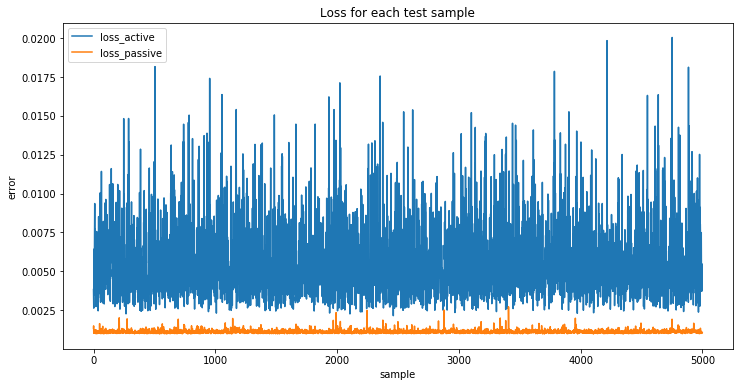

mean qdot passive: 0.00017778488978218422
mean qdot active: 0.0009822198737289981


In [11]:
#########################################
# PLOT LOSS OF EACH SAMPLE
plt.figure(figsize = [12,6])
loss_active = plt.plot(a_losses_total, label = 'loss_active')
loss_passive = plt.plot(p_losses_total, label = 'loss_passive')
plt.legend()
plt.ylabel('error')
plt.xlabel('sample')
plt.title('Loss for each test sample')
plt.show()
a_loss = np.mean(a_losses_qdot)
p_loss = np.mean(p_losses_qdot)
print(f'mean qdot passive: {p_loss}')
print(f'mean qdot active: {a_loss}')